In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

import json
import geopandas as gpd
from copy import deepcopy
import shapely
from shapely.geometry import Point,Polygon,LineString
import pyproj
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### S1 - Distribution of the observed users

In [7]:
# shape file for US metro areas
metromap = gpd.read_file("../data/shapes/tl_2019_us_cbsa/tl_2019_us_cbsa.shp")

# manipulations
metromap.set_geometry("geometry",inplace=True)
metromap["GEOID"] = metromap["GEOID"].astype(int)

# cbsa info table
cbsa_info = pd.read_csv("../data/cbsacode_shortname_tracts.csv", sep=";", index_col=0)

# manipulations
cbsa_info = cbsa_info.loc[:,["cbsacode", "short_name"]].drop_duplicates()
cbsa_info["selected"] = 1
cbsa_info["color"] = "darkblue"

# merge for plot
metromap = pd.merge(
    metromap,
    cbsa_info,
    left_on="GEOID",
    right_on="cbsacode",
    how="left"
)

# correction on the final dataframe
metromap["selected"] = metromap["selected"].fillna(0)
metromap["color"] = metromap["color"].fillna("lightgray")

# shape file for US states
usmap = gpd.read_file("../data/shapes/tl_2017_us_state/tl_2017_us_state.shp")

# manipulations
usmap.set_geometry("geometry",inplace=True)

In [8]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"] >= 10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# merge
degree_tab = pd.merge(
    degree_tab,
    users,
    left_on="user_id",
    right_on="user_id1",
    how="left"
)

# user count per cbsa
users_cbsa = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()

In [9]:
# metro area names and population
metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[users_cbsa["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP", ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"}, axis=1, inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])
metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

# merge user counts
metrodata = pd.merge(users_cbsa, metrodata, on="cbsacode")
metrodata = metrodata.sort_values(by=['rank'])

/usr/local/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
<ipython-input-12-bd4f8f028e71>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=metrodata['short_name'], rotation=90)


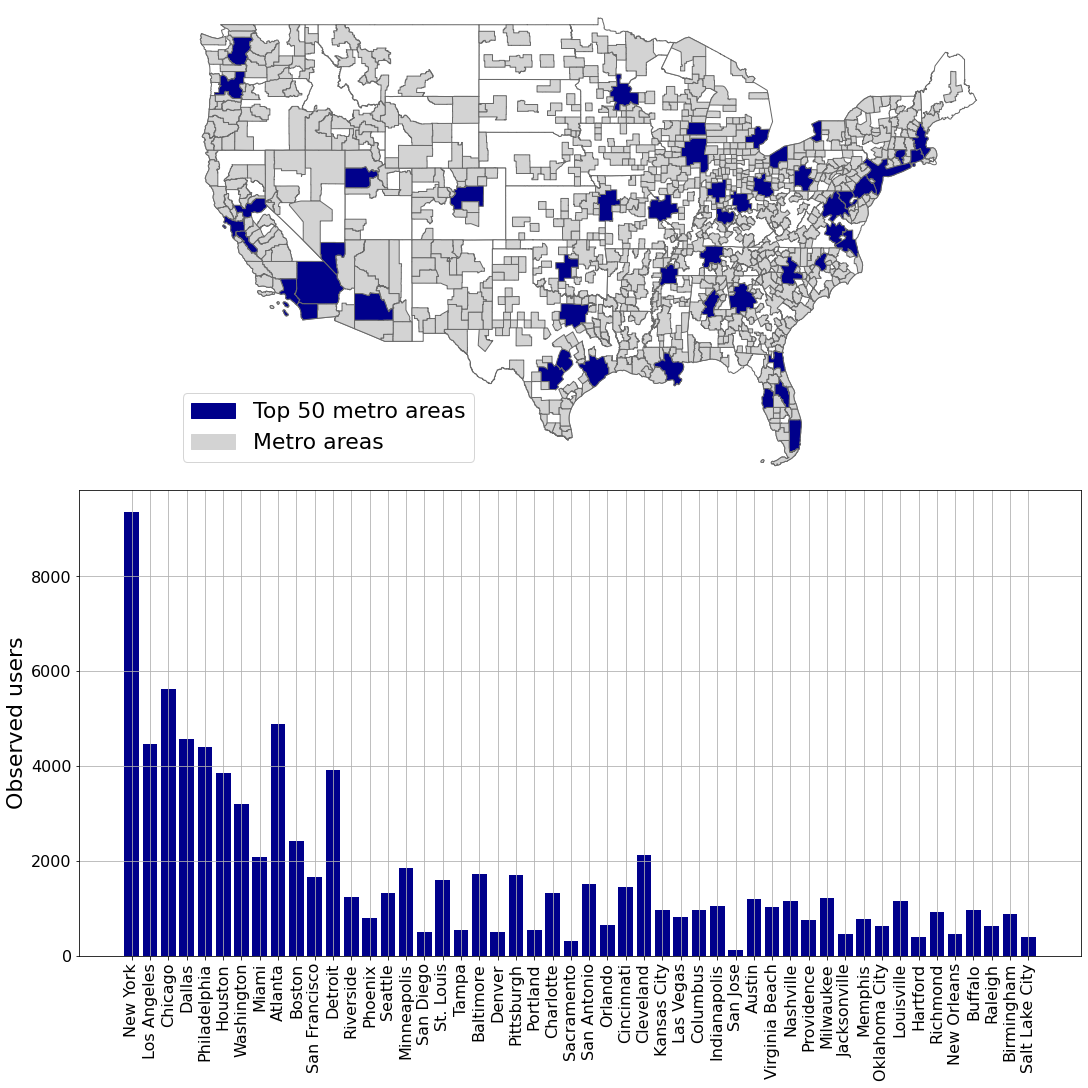

In [12]:
fig, ax = plt.subplots(2,1, figsize = (15,15), constrained_layout=True)
plt.rcParams['font.size']=16
plt.rc('legend', fontsize=22)

# MAP
usmap.plot(ax=ax[0], color="white", edgecolor='dimgray')
metromap.plot(ax=ax[0], column="selected", color=metromap["color"], edgecolor='dimgray')
ax[0].set_xlim([-127,-66])
ax[0].set_ylim([24,50])
ax[0].axis('off')

top50metro = mpatches.Patch(color='darkblue', label='Top 50 metro areas')
allmetro = mpatches.Patch(color='lightgray', label='Metro areas')
ax[0].legend(handles=[top50metro, allmetro], loc='lower left')

# distribution
ax[1].bar(metrodata["short_name"], metrodata["user_id"], color="darkblue")
ax[1].set_xticklabels(labels="", rotation=90)
ax[1].grid()
ax[1].set_xticklabels(labels=metrodata['short_name'], rotation=90)
ax[1].set_ylabel("Observed users", size=22)

plt.show()

### S2 - Population and observed users in metro areas

In [18]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# merge
degree_tab = pd.merge(
    degree_tab,
    users,
    left_on="user_id",
    right_on="user_id1",
    how="left"
)

# user count per cbsa
user_df = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()
user_df.columns = ["cbsacode", "nr_users"]

In [19]:
# add observed users to metrodata
metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[user_df["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])
metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

# user counts
metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.reset_index()
metrodata = pd.merge(
    metrodata,
    user_df,
    on="cbsacode",
    how="left"
)

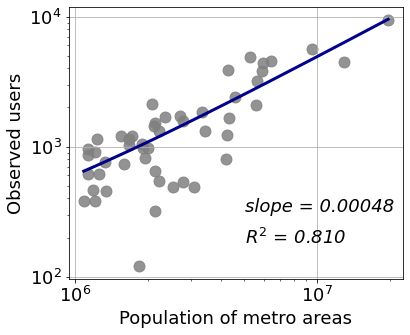

In [20]:
# scatter with regression line
fig, ax = plt.subplots(figsize = (6,5))
plt.rcParams['font.size']=18

X = (metrodata["population"]).values.reshape(-1, 1) 
Y = (metrodata["nr_users"]).values.reshape(-1, 1) 
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(metrodata.population, metrodata.nr_users, s=120, color='grey', alpha=0.85)
plt.plot(X, Y_pred, color='darkblue', linewidth=3)
plt.xlabel("Population of metro areas")
plt.ylabel("Observed users")
plt.loglog()

plt.text(10**6.7, 10**2.5, ("slope = " + str(linear_regressor.coef_[0][0])[:7]), style='italic')
plt.text(10**6.7, 10**2.25, ("$R^2$ = " + str(r2_score(Y, Y_pred))[:5]), style='italic')

plt.grid()
plt.show()

In [28]:
# population in diff income deciles
censusdata2012 = pd.read_csv("../data/original_files/censusdata_top50_2012.csv")

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

censusdata2012['geoid'] = censusdata2012.apply(create_geoid,axis=1)

# keep interesting columns
censusdata2012 = censusdata2012[['geoid', 'population', 'education_bachelor', 'income']]

# cleaning
censusdata2012 = censusdata2012[censusdata2012["income"]>1500]
censusdata2012["BA_share"] = censusdata2012["education_bachelor"] / censusdata2012["population"]


# add cbsacode to censusdata
userdata = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_tract = userdata[["user_id", "tract_home"]]

temp1 = userdata[["cbsacode", "tract_home"]].rename(columns={"tract_home":"tract_id"})
temp2 = userdata[["cbsacode", "tract_work"]].rename(columns={"tract_work":"tract_id"})
temp = pd.concat([temp1, temp2]).drop_duplicates()
censusdata2012 = pd.merge(
    censusdata2012,
    temp,
    left_on="geoid",
    right_on="tract_id",
    how="left"
)

In [29]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# add census info to users
users = pd.merge(
    degree_tab,
    users,
    left_on="user_id",
    right_on="user_id1",
    how="left"
)
users = pd.merge(
    users,
    user_tract,
    on="user_id",
    how="left"
)
users = pd.merge(
    users,
    censusdata2012,
    left_on=["tract_home", "cbsacode"],
    right_on=["tract_id", "cbsacode"],
    how="left"
)

# log transfer
censusdata2012["log_income"] = np.log10(censusdata2012["income"] +1)
users["log_income"] = np.log10(users["income"] +1)
users = users.dropna()

In [30]:
# not so elegant way to population weight the prepared plot
multi = np.array(censusdata2012["population"])

x = censusdata2012[["tract_id", "log_income"]].values
census_multi_income = pd.DataFrame(np.repeat(x, multi, axis=0))
census_multi_income.columns = ["tract_id", "log_income"]
census_multi_income = pd.merge(
    census_multi_income,
    temp,
    on="tract_id",
    how="left"
)

x2 = censusdata2012[["tract_id", "BA_share"]].values
census_multi_BA = pd.DataFrame(np.repeat(x2, multi, axis=0))
census_multi_BA.columns = ["tract_id", "BA_share"]
census_multi_BA = pd.merge(
    census_multi_BA,
    temp,
    on="tract_id",
    how="left"
)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

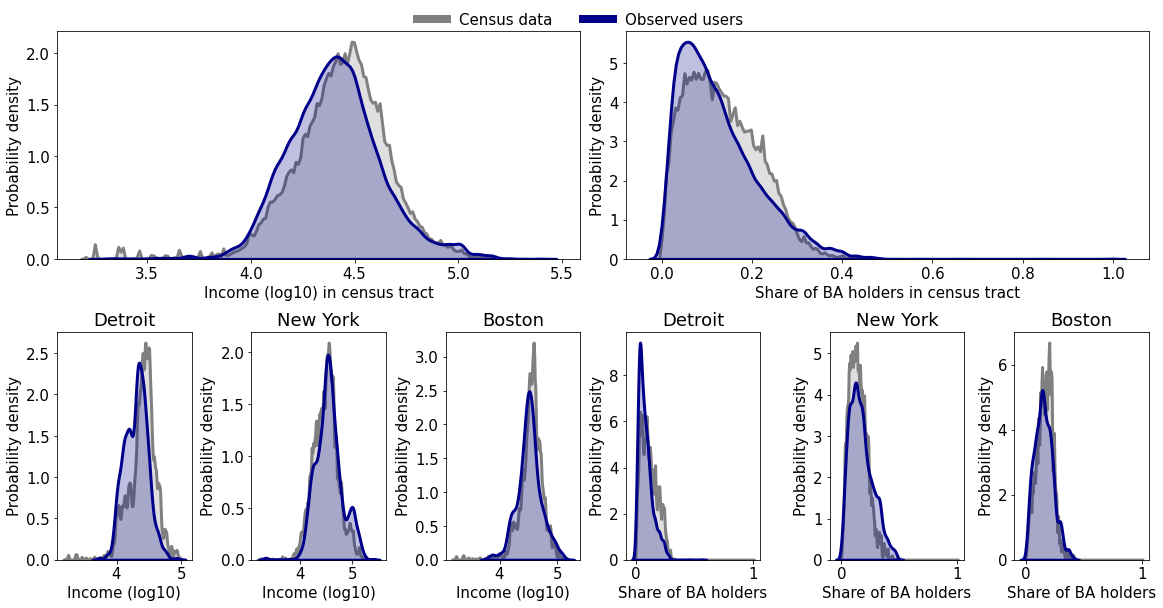

In [31]:
# plot construction

fig = plt.figure(figsize=(16,8), constrained_layout=True)
plt.rcParams['font.size'] = 15

ax = [0]*8
gs = GridSpec(2,6,figure=fig, height_ratios = [0.5,0.5])

# grids
ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[0,3:6])
ax[2] = fig.add_subplot(gs[1,0])
ax[3] = fig.add_subplot(gs[1,1])
ax[4] = fig.add_subplot(gs[1,2])
ax[5] = fig.add_subplot(gs[1,3])
ax[6] = fig.add_subplot(gs[1,4])
ax[7] = fig.add_subplot(gs[1,5])


# income -- all cbsas
sns.distplot(census_multi_income['log_income'], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[0])
sns.distplot(users['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[0])
ax[0].set_xlabel("Income (log10) in census tract")
ax[0].set_ylabel("Probability density")

# BA -- all cbsas
sns.distplot(census_multi_BA['BA_share'], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[1])
sns.distplot(users['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[1])
ax[1].set_xlabel("Share of BA holders")
ax[1].set_xlabel("Share of BA holders in census tract")
ax[1].set_ylabel("Probability density")

# Detroit 19820
sns.distplot(census_multi_income[census_multi_income["cbsacode"]==19820]["log_income"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[2])
sns.distplot(users[users["cbsacode"]==19820]['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[2])
ax[2].set_xlabel("Income (log10)")
ax[2].set_ylabel("Probability density")
ax[2].set_title("Detroit")

sns.distplot(census_multi_BA[census_multi_BA["cbsacode"]==19820]["BA_share"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[5])
sns.distplot(users[users["cbsacode"]==19820]['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[5])
ax[5].set_xlabel("Share of BA holders")
ax[5].set_ylabel("Probability density")
ax[5].set_title("Detroit")

# New York 35620
sns.distplot(census_multi_income[census_multi_income["cbsacode"]==35620]["log_income"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[3])
sns.distplot(users[users["cbsacode"]==35620]['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[3])
ax[3].set_xlabel("Income (log10)")
ax[3].set_ylabel("Probability density")
ax[3].set_title("New York")

sns.distplot(census_multi_BA[census_multi_BA["cbsacode"]==35620]["BA_share"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[6])
sns.distplot(users[users["cbsacode"]==35620]['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[6])
ax[6].set_xlabel("Share of BA holders")
ax[6].set_ylabel("Probability density")
ax[6].set_title("New York")

# Boston 14460
sns.distplot(census_multi_income[census_multi_income["cbsacode"]==14460]["log_income"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[4])
sns.distplot(users[users["cbsacode"]==14460]['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[4])
ax[4].set_xlabel("Income (log10)")
ax[4].set_ylabel("Probability density")
ax[4].set_title("Boston")

sns.distplot(census_multi_BA[census_multi_BA["cbsacode"]==14460]["BA_share"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[7])
sns.distplot(users[users["cbsacode"]==14460]['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[7])
ax[7].set_xlabel("Share of BA holders")
ax[7].set_ylabel("Probability density")
ax[7].set_title("Boston")


# legend
custom_lines = [Line2D([0], [0], color='grey',  lw=8),Line2D([0], [0], color='darkblue', lw=8)]
labels = [ 'Census data', 'Observed users']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=2, frameon=False, fontsize=15)

plt.show()

### S3 - Distribution of social capital concentration by income groups and metro areas

In [2]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

# clustering data
clust_tab = pd.read_csv("../data/clust_tab_top50.csv.gz")
clust_tab = clust_tab.merge(
    degree_tab[['user_id', 'poor','short_name']],
    on = "user_id",
    how = "left"
)

# support data
supp_tab = pd.read_csv("../data/supp_tab_top50.csv.gz")
supp_tab = supp_tab.merge(
    degree_tab[['user_id', 'short_name', 'poor']],
    on = "user_id",
    how = "left"
)

In [3]:
# user count per cbsa
users_cbsa = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()

metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[users_cbsa["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])
metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

In [4]:
def boxplots_by_distance(df, col_list, axis_names_list, poor):
    """function to plot above / below median distributions by metropolitan area"""
    if poor==1:
        choosen_color = "grey"
        marker_color = "darkblue"
        df = df[df["poor"]==1]
        df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')
    else:
        choosen_color = "darkblue"
        marker_color = "grey"
        df = df[df["poor"]==0]
        df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')    

    fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)
    sns.boxplot(x= "short_name", y=col_list[0], data=df, color=choosen_color,\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":marker_color, "markeredgecolor":marker_color},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])
    ax[0].xaxis.label.set_visible(False)
    ax[0].set_ylabel(axis_names_list[0], size=20)

    sns.boxplot(x= "short_name", y=col_list[1], data=df, color=choosen_color,\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":marker_color, "markeredgecolor":marker_color},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])
    ax[1].xaxis.label.set_visible(False)
    ax[1].set_ylabel(axis_names_list[1], size=20)

    sns.boxplot(x= "short_name", y=col_list[2], data=df, color=choosen_color,\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":marker_color, "markeredgecolor":marker_color},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])
    ax[2].xaxis.label.set_visible(False)
    ax[2].set_ylabel(axis_names_list[2], size=20)

    sns.boxplot(x= "short_name", y=col_list[3], data=df, color=choosen_color,\
                showmeans=True, meanprops={"marker":"s","markerfacecolor":marker_color, "markeredgecolor":marker_color},\
                showfliers=False, ax=ax[3], order = metrodata["short_name"])
    ax[3].set_ylabel(axis_names_list[3], size=20)
    ax[3].xaxis.label.set_visible(False)
    plt.xticks(rotation=90)

<ipython-input-4-668986e206ae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')


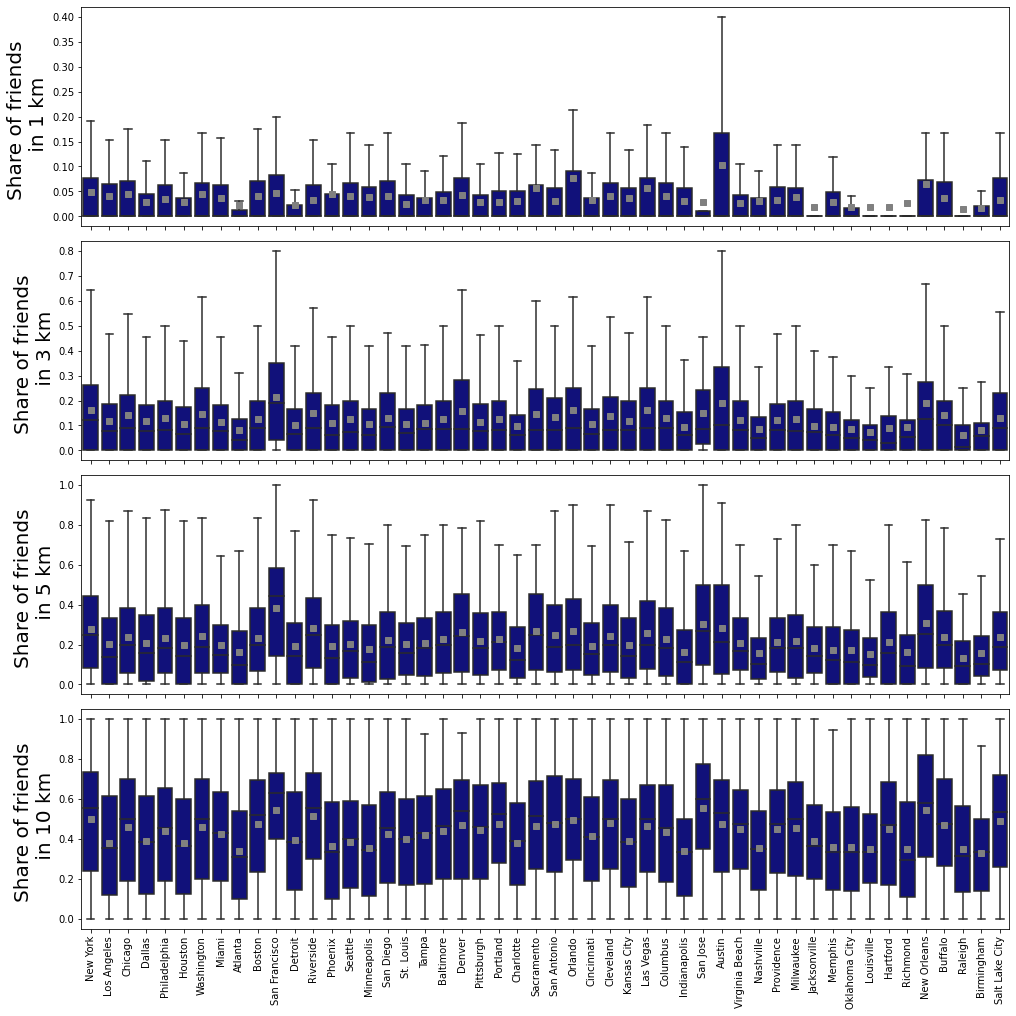

In [5]:
# Figure S4
cols = ["dcum1000_share", "dcum3000_share", "dcum5000_share", "dcum10000_share"]
axis_names = ["Share of friends \n in 1 km", "Share of friends \n in 3 km", "Share of friends \n in 5 km", "Share of friends \n in 10 km"]
boxplots_by_distance(degree_tab, cols, axis_names, poor=0)

<ipython-input-4-668986e206ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')


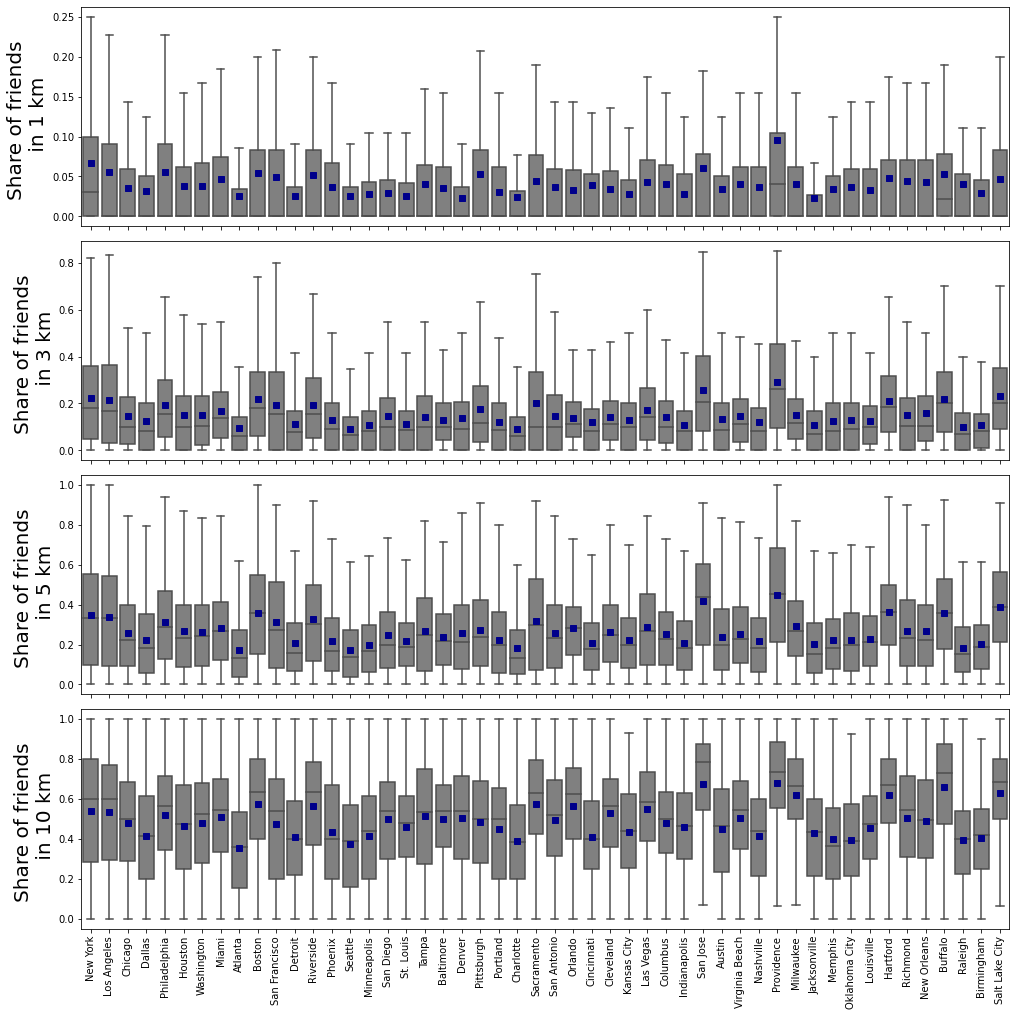

In [7]:
# Figure S5
cols = ["dcum1000_share", "dcum3000_share", "dcum5000_share", "dcum10000_share"]
axis_names = ["Share of friends \n in 1 km", "Share of friends \n in 3 km", "Share of friends \n in 5 km", "Share of friends \n in 10 km"]
boxplots_by_distance(degree_tab, cols, axis_names, poor=1)

<ipython-input-4-668986e206ae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')


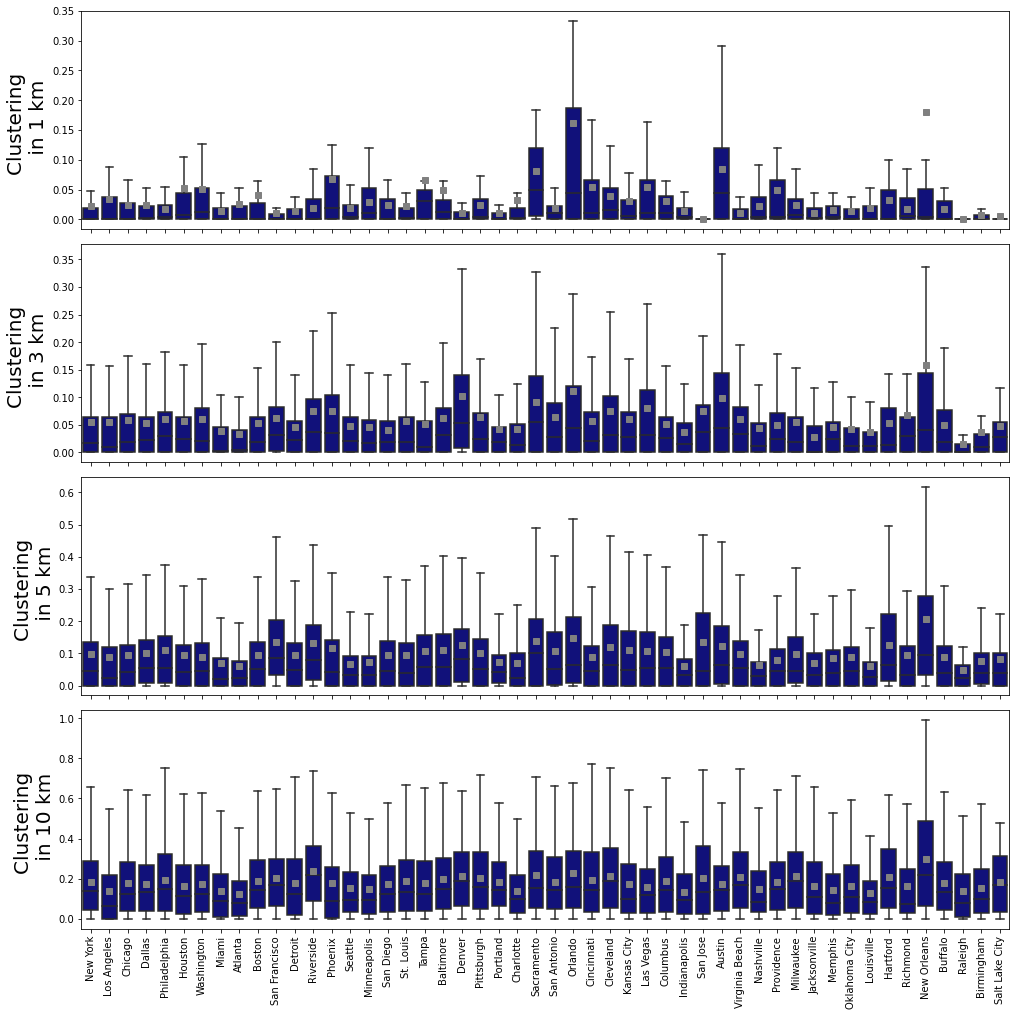

In [8]:
# Figure S6
cols = ["clust1000", "clust3000", "clust5000", "clust10000"]
axis_names = ["Clustering \n in 1 km", "Clustering \n in 3 km", "Clustering \n in 5 km", "Clustering \n in 10 km"]
boxplots_by_distance(clust_tab, cols, axis_names, poor=0)

<ipython-input-4-668986e206ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')


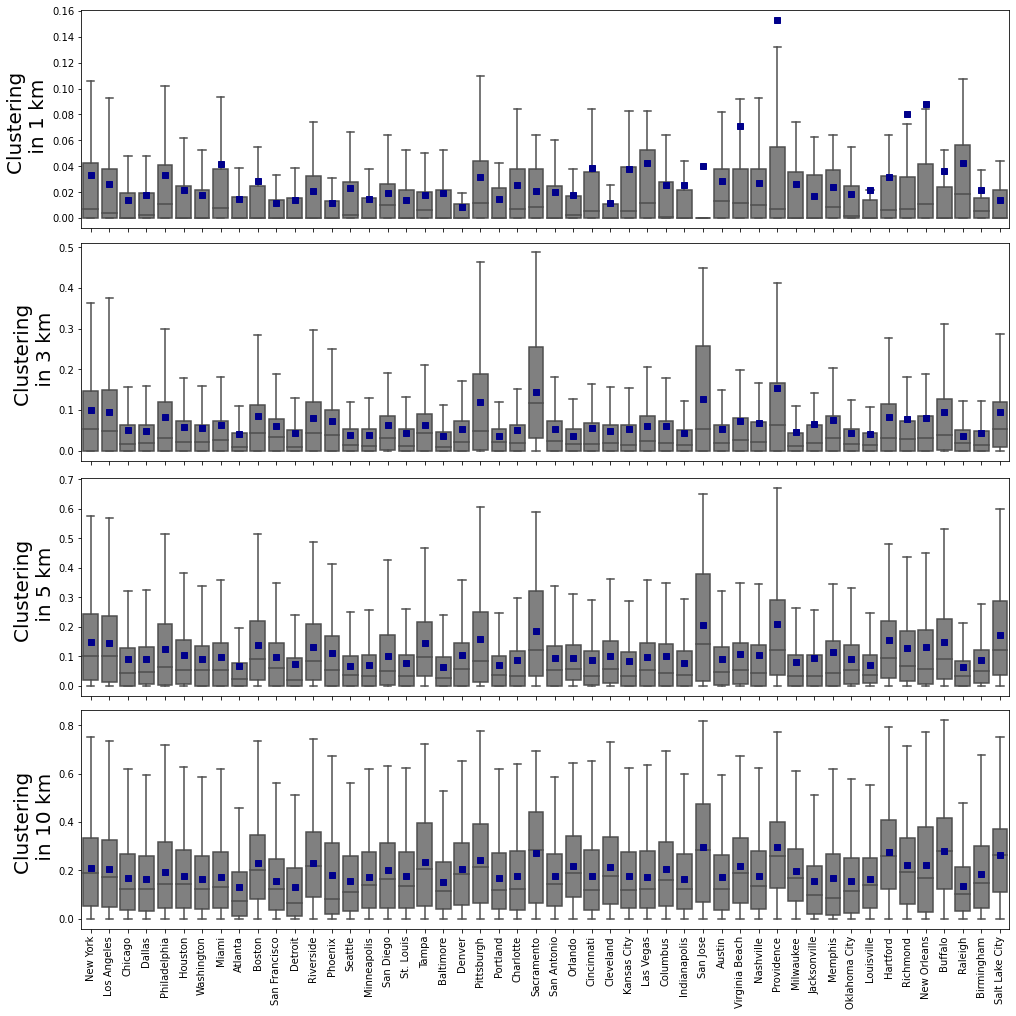

In [9]:
# Figure S7
cols = ["clust1000", "clust3000", "clust5000", "clust10000"]
axis_names = ["Clustering \n in 1 km", "Clustering \n in 3 km", "Clustering \n in 5 km", "Clustering \n in 10 km"]
boxplots_by_distance(clust_tab, cols, axis_names, poor=1)

<ipython-input-4-668986e206ae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')


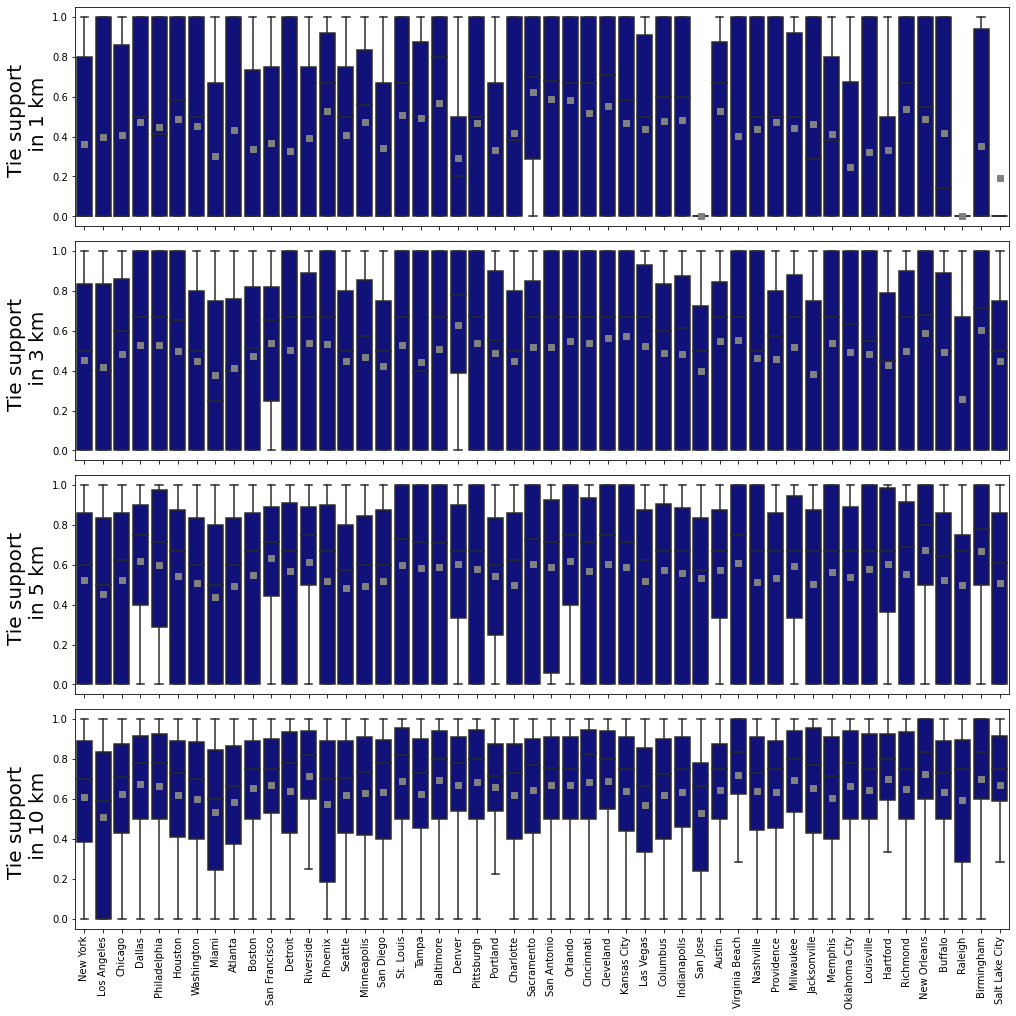

In [13]:
# Figure S8
cols = ["support1000", "support3000", "support5000", "support10000"]
axis_names = ["Tie support \n in 1 km", "Tie support \n in 3 km", "Tie support \n in 5 km", "Tie support \n in 10 km"]
boxplots_by_distance(supp_tab, cols, axis_names, poor=0)

<ipython-input-4-668986e206ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_name"] = df["short_name"].replace('Louisville/Jefferson County','Louisville')


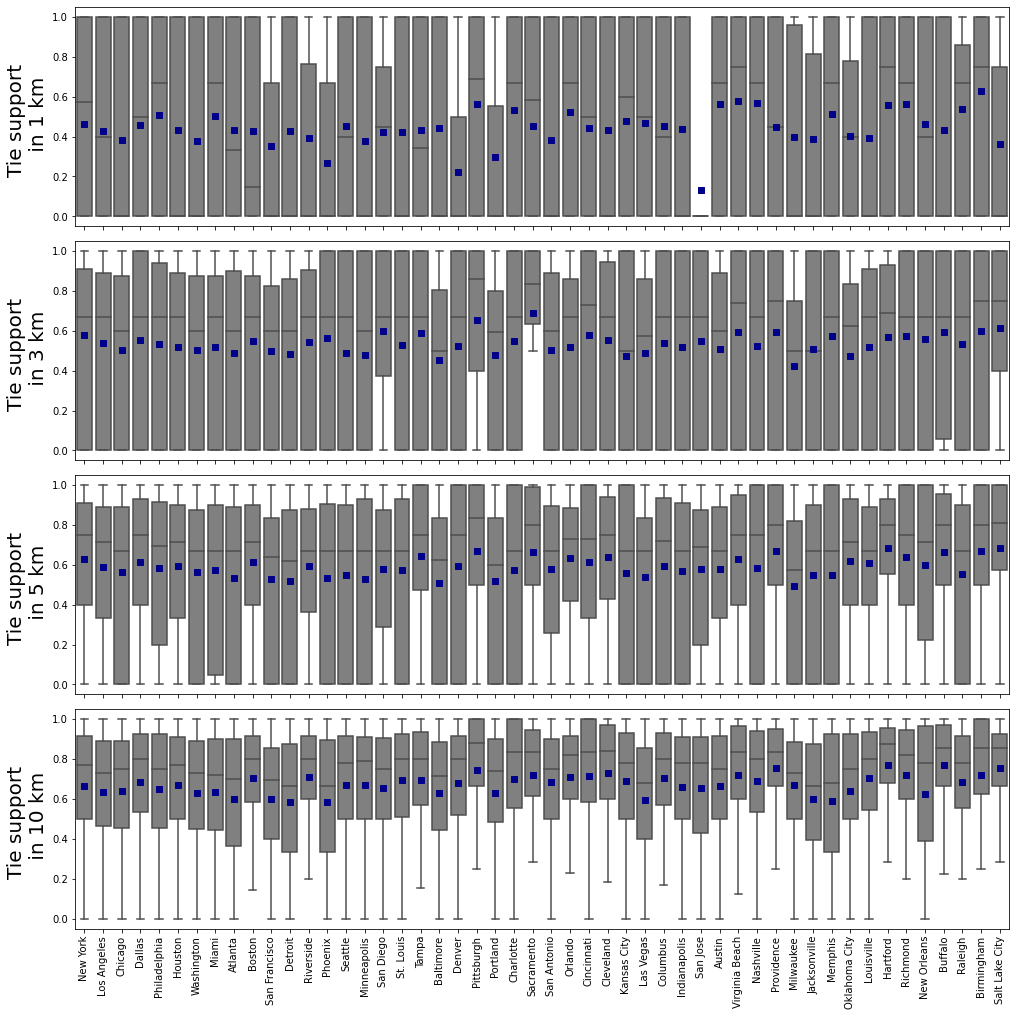

In [15]:
# Figure S9
cols = ["support1000", "support3000", "support5000", "support10000"]
axis_names = ["Tie support \n in 1 km", "Tie support \n in 3 km", "Tie support \n in 5 km", "Tie support \n in 10 km"]
boxplots_by_distance(supp_tab, cols, axis_names, poor=1)